In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [3]:
import tensorflow_datasets as tfds

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

train_horses = train_horses.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

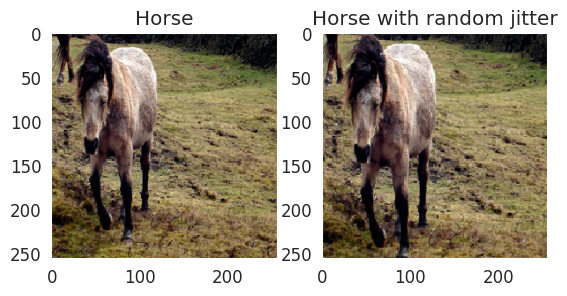

In [5]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

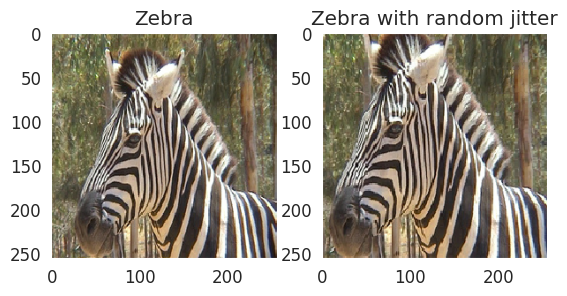

In [6]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

In [7]:
def generator():
    image_input=Input(shape=(256, 256, 3))
    downsample = tf.keras.layers.Conv2D(filters=64, kernel_size=7,padding='same', strides=1,activation='relu')(image_input)
    downsample = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2,padding='same',activation='relu')(downsample)
    downsample = tf.keras.layers.Conv2D(filters=128*2, kernel_size=3, strides=2,padding='same',activation='relu')(downsample)

    tunnels=tf.keras.layers.Conv2D(filters=128*2, kernel_size=3, strides=1,padding='same',activation='relu')(downsample)
    tunnels=tf.keras.layers.Conv2D(filters=128*2, kernel_size=3, strides=1,padding='same',activation='relu')(tunnels)
    tunnels=tf.keras.layers.Conv2D(filters=128*2, kernel_size=3, strides=1,padding='same',activation='relu')(tunnels)
    tunnels=tf.keras.layers.Conv2D(filters=128*2, kernel_size=3, strides=1,padding='same',activation='relu')(tunnels)
    tunnels=tf.keras.layers.Conv2D(filters=128*2, kernel_size=3, strides=1,padding='same',activation='relu')(tunnels)
    tunnels=tf.keras.layers.Conv2D(filters=128*2, kernel_size=3, strides=1,padding='same',activation='relu')(tunnels)

    upsample=tf.keras.layers.Conv2DTranspose(filters=128*2, kernel_size=3, strides=2,padding='same',activation='relu')(tunnels)
    upsample=tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2,padding='same',activation='relu')(upsample)

    image_out=tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=7, strides=1,padding='same',activation='tanh')(upsample)
    model=Model(inputs=[image_input], outputs=image_out)
    return model

In [8]:
def discriminator():
    image_input=Input(shape=(256, 256, 3))

    downsample = tf.keras.layers.Conv2D(filters=64, kernel_size=4,padding='same', strides=2,activation='relu')(image_input)
    downsample = tf.keras.layers.Conv2D(filters=64*2, kernel_size=4,padding='same', strides=2,activation='relu')(downsample)
    downsample = tf.keras.layers.Conv2D(filters=64*2*2, kernel_size=4,padding='same', strides=2,activation='relu')(downsample)
    downsample = tf.keras.layers.Conv2D(filters=64*2, kernel_size=4,padding='same', strides=2,activation='relu')(downsample)

    output=tf.keras.layers.Conv2D(filters=1, kernel_size=4,padding='same', strides=1,activation='sigmoid')(downsample)
    model=Model(inputs=[image_input], outputs=output)
    return model

In [9]:
image_input1 = Input(shape=(256, 256, 3))
image_input2 = Input(shape=(256, 256, 3))

generator_G=generator()
generator_F=generator()
discriminator_Y=discriminator()
discriminator_X=discriminator()

generator_G_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_F_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)




In [10]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)


def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


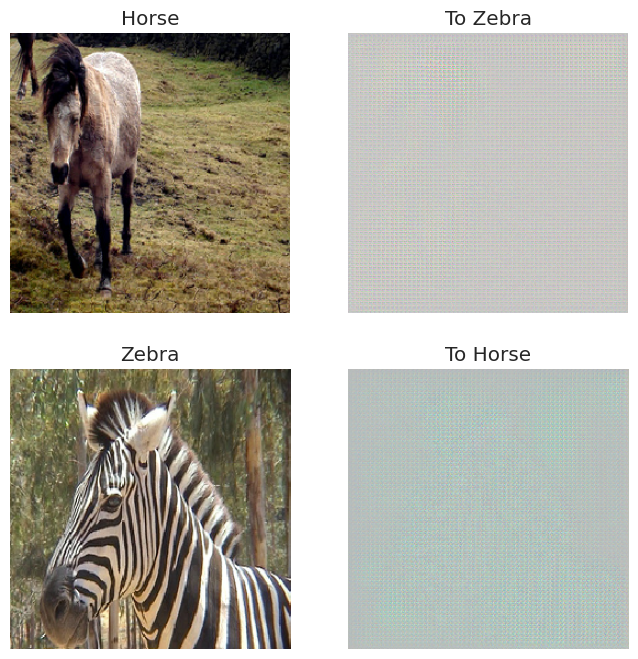

In [11]:
import matplotlib.pyplot as plt

# Assuming sample_horse and sample_zebra are the input images
to_zebra = generator_G.predict(sample_horse)
to_horse = generator_F.predict(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
    plt.subplot(2, 2, i + 1)
    plt.title(title[i])
    img = imgs[i][0]
    if i % 2 == 0:
        plt.imshow(img * 0.5 + 0.5)
    else:
        img = img * contrast
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
        plt.imshow(img * 0.5 + 0.5)
    plt.axis('off')
plt.show()


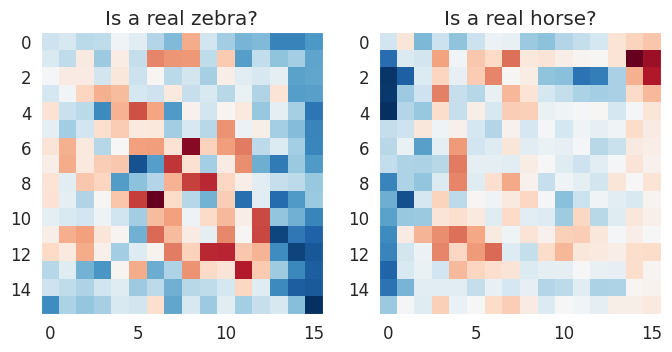

In [12]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_Y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_X(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [13]:
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_G(real_x, training=True)
    cycled_x = generator_F(fake_y, training=True)

    fake_x = generator_F(real_y, training=True)
    cycled_y = generator_G(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_F(real_x, training=True)
    same_y = generator_G(real_y, training=True)

    disc_real_x = discriminator_X(real_x, training=True)
    disc_real_y = discriminator_Y(real_y, training=True)

    disc_fake_x = discriminator_X(fake_x, training=True)
    disc_fake_y = discriminator_Y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_G.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_F.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_X.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_Y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_G_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_G.trainable_variables))

  generator_F_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_F.trainable_variables))

  discriminator_X_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_X.trainable_variables))

  discriminator_Y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_Y.trainable_variables))

In [16]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()
EPOCHS = 5


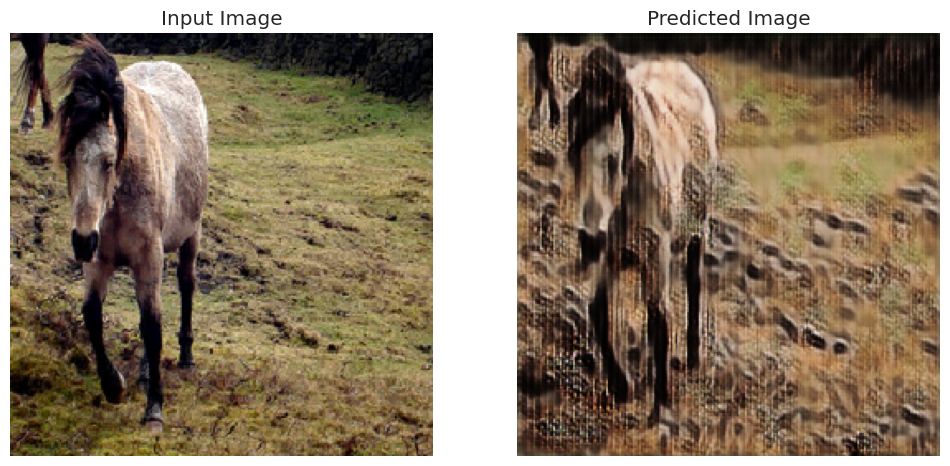

In [ ]:
for epoch in range(EPOCHS):
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)

  clear_output(wait=True)
  generate_images(generator_G, sample_horse)